<div style="border: 1px solid thistle; padding: 5px 20px 10px 20px;">
    <h2><font color = "77658f" style=";">Feedback</font></h2><br>
    <font color = "77658f">The problem statement should be linked to a particular issue (better if it can be referenced to a real world use) to make it more specific. Background of the property market situation in Ames, and a description of your project workflow would be good to include.<br>
        Good cleaning of data. Elaboration of features selection and tying it to problem statement can be better. No conclusion for the prediction. Overall it can be better with more elaboration on the thought process behind your coding decisions.<br><br>
    </font>
</div>


### [Contents:](#Contents:)
[Libraries import](#Libraries-import) |
[Ames Housing-Train](#Ames-Housing-Train) |
[Exploratory Data Analysis & Data Visualization](#Exploratory-Data-Analysis-&-Data-Visualization) |
[Modeling](#Modeling) |
[Ames Housing-Test Dataset](#Ames-Housing-Test-Dataset) |
[Outside Research](#Outside-Research) 

## [Libraries import](#Libraries-import)
[Contents:](#Contents:)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE

%matplotlib inline

plt.style.use('seaborn')
sns.set_style('ticks')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## [Ames Housing-Train](#Ames-Housing-Train)
[Contents:](#Contents:)

In [10]:
### Your code: ames_train = pd.read_csv('../project_2/datasets/train.csv')
### If the folder datasets is saved within the same directory as this ipynb notebook, there's no need to
### go up to project_2 folder
ames_train = pd.read_csv('./datasets/train.csv')

In [11]:
#replacing empty space with underscore(_)
ames_train.columns = [x.replace(' ', '_') for x in ames_train.columns]
ames_train.head()

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [12]:
print(ames_train.shape)
print(ames_train.info())

(2051, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS_SubClass        2051 non-null int64
MS_Zoning          2051 non-null object
Lot_Frontage       1721 non-null float64
Lot_Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot_Shape          2051 non-null object
Land_Contour       2051 non-null object
Utilities          2051 non-null object
Lot_Config         2051 non-null object
Land_Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition_1        2051 non-null object
Condition_2        2051 non-null object
Bldg_Type          2051 non-null object
House_Style        2051 non-null object
Overall_Qual       2051 non-null int64
Overall_Cond       2051 non-null int64
Year_Built         2051 non-null int64
Year_Remod/Add     2051 non-null int64
Roof_Style

In [13]:
#use.sum().sum() to get a rough number of total null
print(ames_train.isnull().sum().sum())

9822


### <summary>After browsing through the columns with data dictionary and trying some .unique(), I will deem some columns to be totally irrelevant to the sales price of a house.</summary>

- Irrelevant columns
    - Id
    - PID                                   
    - Pool_QC (Too many NaN)
    - Fence (Too many NaN)
    - Garage_Yr_Blt (Too many NaN and irrelevant)
    - Misc_Feature (Too many NaN and MiscVal can explain this column)

In [14]:
ames_train['Pool_QC'].value_counts()  #low value count for this column

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool_QC, dtype: int64

In [15]:
ames_train['Garage_Yr_Blt'].isnull().sum()  #irrelevant

114

In [16]:
ames_train['Fence'].value_counts()   #irrelevant

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64

In [17]:
#dropping irrelevant/columns with too many null values
irre_col = ['Id','PID','Pool_QC','Fence','Garage_Yr_Blt','Misc_Feature']

ames_train.drop(irre_col, axis=1, inplace=True)

In [18]:
ames_train.shape

(2051, 75)

In [19]:
#Nominal - dummy variables creation

MSZoning_dummy = pd.get_dummies(ames_train['MS_Zoning'], columns = ['RL', 'RM', 'FV', 'C (all)', 'A (agr)', 'RH', 'I (all)'])
Street_dummy = pd.get_dummies(ames_train['Street'], columns = ['Pave', 'Grvl'])
ames_train['Alley'] = ames_train['Alley'].fillna('NA') #assuming nan-values as No alley access 
Alley_dummy = pd.get_dummies(ames_train['Alley'], columns = ['NA', 'Pave', 'Grvl'])
LandContour_dummy = pd.get_dummies(ames_train['Land_Contour'], columns = ['Lvl', 'HLS', 'Bnk', 'Low'])
LotConfig_dummy = pd.get_dummies(ames_train['Lot_Config'], columns = ['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3']) 
Neighborhood_dummy = pd.get_dummies(ames_train['Neighborhood'], columns = ['Sawyer', 'SawyerW', 'NAmes', 'Timber', 'Edwards', 'OldTown',
       'BrDale', 'CollgCr', 'Somerst', 'Mitchel', 'StoneBr', 'NridgHt',
       'Gilbert', 'Crawfor', 'IDOTRR', 'NWAmes', 'Veenker', 'MeadowV',
       'SWISU', 'NoRidge', 'ClearCr', 'Blmngtn', 'BrkSide', 'NPkVill',
       'Blueste', 'GrnHill', 'Greens', 'Landmrk'])
Condition1_dummy = pd.get_dummies(ames_train['Condition_1'], columns = ['RRAe', 'Norm', 'PosA', 'Artery', 'Feedr', 'PosN', 'RRAn', 'RRNe','RRNn'])
Condition2_dummy = pd.get_dummies(ames_train['Condition_2'], columns = ['RRAe', 'Norm', 'PosA', 'Artery', 'Feedr', 'PosN', 'RRAn', 'RRNe','RRNn'])
BldgType_dummy = pd.get_dummies(ames_train['Bldg_Type'], columns = ['1Fam', 'TwnhsE', 'Twnhs', '2fmCon', 'Duplex'])
HouseStyle_dummy = pd.get_dummies(ames_train['House_Style'], columns = ['2Story', '1Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin','1.5Unf'])
RoofStyle_dummy = pd.get_dummies(ames_train['Roof_Style'], columns = ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed'])
RoofMatl_dummy = pd.get_dummies(ames_train['Roof_Matl'], columns = ['CompShg', 'WdShngl', 'Tar&Grv', 'WdShake', 'Membran', 'ClyTile'])
Exterior1_dummy = pd.get_dummies(ames_train['Exterior_1st'], columns = ['HdBoard', 'VinylSd', 'Wd Sdng', 'BrkFace', 'Plywood', 'MetalSd', 'AsbShng', 'CemntBd', 'WdShing', 'Stucco', 'BrkComm', 'Stone', 'CBlock', 'ImStucc', 'AsphShn'])
Exterior2_dummy = pd.get_dummies(ames_train['Exterior_2nd'], columns = ['HdBoard', 'VinylSd', 'Wd Sdng', 'BrkFace', 'Plywood', 'MetalSd', 'AsbShng', 'CemntBd', 'WdShing', 'Stucco', 'BrkComm', 'Stone', 'CBlock', 'ImStucc', 'AsphShn'])
ames_train['Mas_Vnr_Type'] = ames_train['Mas_Vnr_Type'].fillna('None')
MasVnrType_dummy = pd.get_dummies(ames_train['Mas_Vnr_Type'], columns = ['BrkCmn','BrkFace','CBlock','None','Stone'])
Foundation_dummy = pd.get_dummies(ames_train['Foundation'], columns = ['CBlock', 'PConc', 'BrkTil', 'Slab', 'Stone', 'Wood'])
ames_train['Bsmt_Exposure'] = ames_train['Bsmt_Exposure'].fillna('NA')
Exposure_dummy = pd.get_dummies(ames_train['Bsmt_Exposure'], columns = ['Gd','Av','Mn','No','NA'])
Heating_dummy = pd.get_dummies(ames_train['Heating'], columns = ['Floor','GasA','GasW','Grav','OthW','Wall'])
CentralAir_dummy = pd.get_dummies(ames_train['Central_Air'], columns = ['Y', 'N'])
ames_train['Garage_Type'] = ames_train['Garage_Type'].fillna('NA') #assuming nan-values as No Garage
GarageType_dummy = pd.get_dummies(ames_train['Garage_Type'], columns = ['Attchd', 'Detchd', 'BuiltIn', 'Basment', 'NA', '2Types','CarPort'])
SaleType_dummy = pd.get_dummies(ames_train['Sale_Type'], columns = ['WD','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth'])

In [20]:
ames_train = pd.concat([ames_train,MSZoning_dummy,Street_dummy,Alley_dummy,LandContour_dummy,LotConfig_dummy,Neighborhood_dummy,Condition1_dummy,Condition2_dummy,BldgType_dummy,HouseStyle_dummy,RoofStyle_dummy,RoofMatl_dummy,Exterior1_dummy,Exterior2_dummy,MasVnrType_dummy,Foundation_dummy,Exposure_dummy,Heating_dummy,CentralAir_dummy,GarageType_dummy,SaleType_dummy], axis = 1)

In [21]:
dummy_col = ['MS_Zoning','Street','Alley','Land_Contour','Lot_Config','Neighborhood','Condition_1','Condition_2','Bldg_Type','House_Style','Roof_Style','Roof_Matl','Exterior_1st','Exterior_2nd','Mas_Vnr_Type','Foundation','Bsmt_Exposure','Heating','Central_Air','Garage_Type','Sale_Type']
ames_train.drop(columns = dummy_col, inplace = True)

In [22]:
ames_train.shape

(2051, 213)

In [23]:
#Ordinal - mapping numerical value to the original value

ames_train.Lot_Shape = ames_train.Lot_Shape.apply(lambda x: 1 if x == 'Reg' else 0)
ames_train.Utilities = ames_train.Utilities.map({'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1})
ames_train.Land_Slope = ames_train.Land_Slope.map({'Gtl':3,'Mod':2,'Sev':1})
ames_train.Exter_Qual = ames_train.Exter_Qual.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
ames_train.Exter_Cond = ames_train.Exter_Cond.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
ames_train.Bsmt_Qual = ames_train.Bsmt_Qual.fillna('NA') #assuming nan-values as No Basement
ames_train.Bsmt_Qual = ames_train.Bsmt_Qual.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_train.Bsmt_Cond = ames_train.Bsmt_Cond.fillna('NA') #assuming nan-values as No Basement
ames_train.Bsmt_Cond = ames_train.Bsmt_Cond.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_train.BsmtFin_Type_1 = ames_train.BsmtFin_Type_1.fillna('NA') #assuming nan-values as No Basement
ames_train.BsmtFin_Type_1 = ames_train.BsmtFin_Type_1.map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0})
ames_train.BsmtFin_Type_2 = ames_train.BsmtFin_Type_2.fillna('NA') #assuming nan-values as No Basement
ames_train.BsmtFin_Type_2 = ames_train.BsmtFin_Type_2.map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0})
ames_train.Heating_QC = ames_train.Heating_QC.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
ames_train.Electrical = ames_train.Electrical.fillna('NA')
ames_train.Electrical = ames_train.Electrical.map({'SBrkr':5,'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1,'NA':0})
ames_train.Kitchen_Qual = ames_train.Kitchen_Qual.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
ames_train.Functional = ames_train.Functional.map({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1})
ames_train.Fireplace_Qu = ames_train.Fireplace_Qu.fillna('NA') #assuming nan-values as No Fireplace
ames_train.Fireplace_Qu = ames_train.Fireplace_Qu.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_train.Garage_Finish = ames_train.Garage_Finish.fillna('NA') #assuming nan-values as No Garage
ames_train.Garage_Finish = ames_train.Garage_Finish.map({'Fin':3,'RFn':2,'Unf':1,'NA':0})
ames_train.Garage_Qual = ames_train.Garage_Qual.fillna('NA') #assuming nan-values as No Garage
ames_train.Garage_Qual = ames_train.Garage_Qual.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_train.Garage_Cond = ames_train.Garage_Cond.fillna('NA') #assuming nan-values as No Garage
ames_train.Garage_Cond = ames_train.Garage_Cond.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_train.Paved_Drive = ames_train.Paved_Drive.map({'Y':2,'P':1,'N':0})

In [24]:
ames_train.shape

(2051, 213)

In [25]:
#checking for null value in every column

for x in ames_train:
        print (x + '     ' + str(ames_train[x].isnull().sum()))

MS_SubClass     0
Lot_Frontage     330
Lot_Area     0
Lot_Shape     0
Utilities     0
Land_Slope     0
Overall_Qual     0
Overall_Cond     0
Year_Built     0
Year_Remod/Add     0
Mas_Vnr_Area     22
Exter_Qual     0
Exter_Cond     0
Bsmt_Qual     0
Bsmt_Cond     0
BsmtFin_Type_1     0
BsmtFin_SF_1     1
BsmtFin_Type_2     0
BsmtFin_SF_2     1
Bsmt_Unf_SF     1
Total_Bsmt_SF     1
Heating_QC     0
Electrical     0
1st_Flr_SF     0
2nd_Flr_SF     0
Low_Qual_Fin_SF     0
Gr_Liv_Area     0
Bsmt_Full_Bath     2
Bsmt_Half_Bath     2
Full_Bath     0
Half_Bath     0
Bedroom_AbvGr     0
Kitchen_AbvGr     0
Kitchen_Qual     0
TotRms_AbvGrd     0
Functional     0
Fireplaces     0
Fireplace_Qu     0
Garage_Finish     0
Garage_Cars     1
Garage_Area     1
Garage_Qual     0
Garage_Cond     0
Paved_Drive     0
Wood_Deck_SF     0
Open_Porch_SF     0
Enclosed_Porch     0
3Ssn_Porch     0
Screen_Porch     0
Pool_Area     0
Misc_Val     0
Mo_Sold     0
Yr_Sold     0
SalePrice     0
A (agr)     0
C (all) 

In [26]:
#assuming these columns with null values are representing nothing in their respective variables,
#i will be filling them with zero.

zero_col = ['Lot_Frontage','Mas_Vnr_Area','BsmtFin_SF_1','BsmtFin_SF_2','Bsmt_Unf_SF','Total_Bsmt_SF','Bsmt_Full_Bath','Bsmt_Half_Bath','Garage_Cars','Garage_Area']

ames_train[zero_col] = ames_train[zero_col].fillna(0)

In [27]:
ames_train.isnull().sum().sum()

0

In [28]:
ames_train.shape

(2051, 213)

#### Deleting outliers

In [29]:
#adding columns with dtypes(int64 or float 64) to a list

int_float_col = []

for x in ames_train:
    if ((ames_train[x].dtypes == 'int64') | (ames_train[x].dtypes == 'float64')):
        int_float_col.append(x)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [30]:
ames_int_float = ames_train[int_float_col]

C:\Users\ym_ch\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


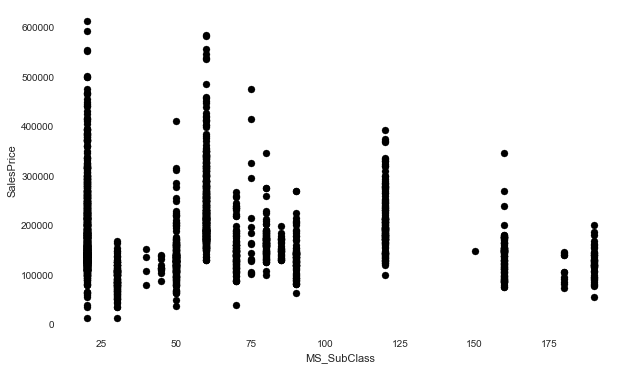

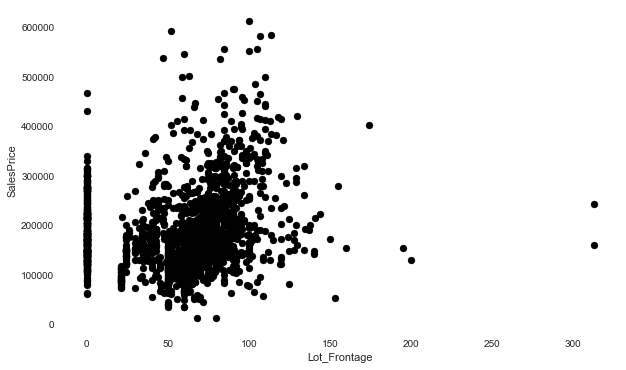

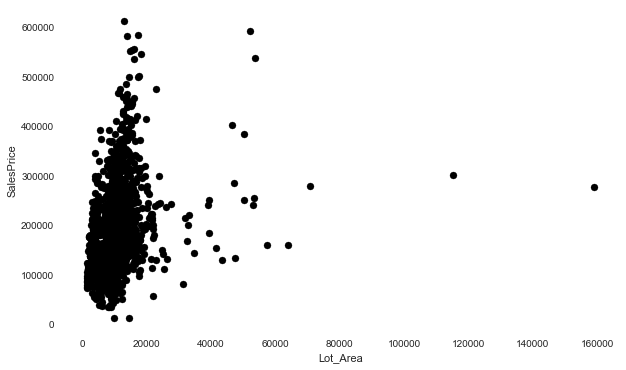

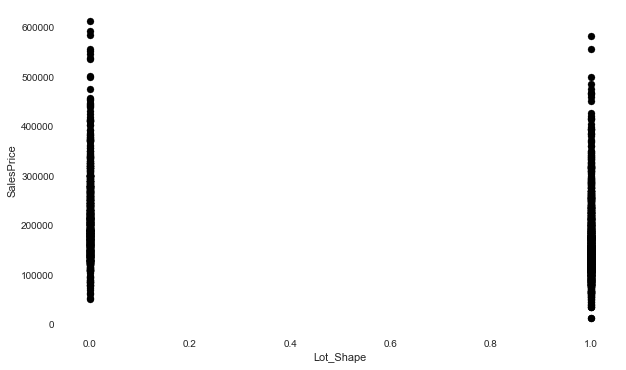

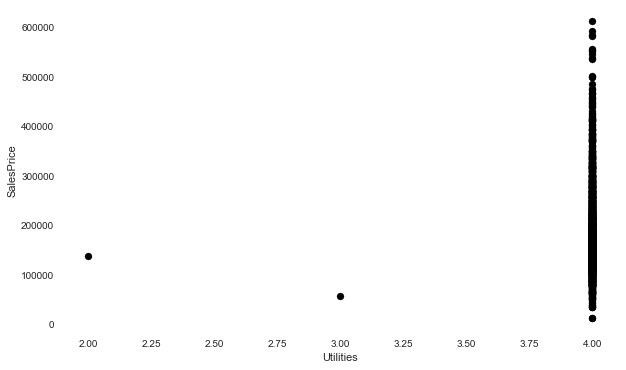

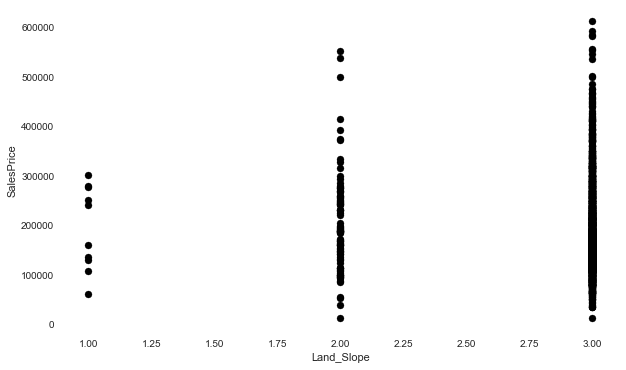

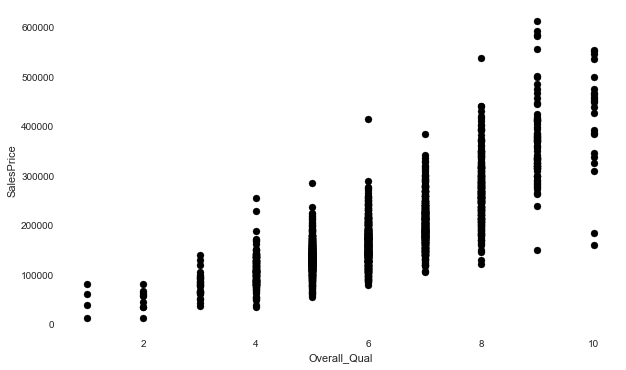

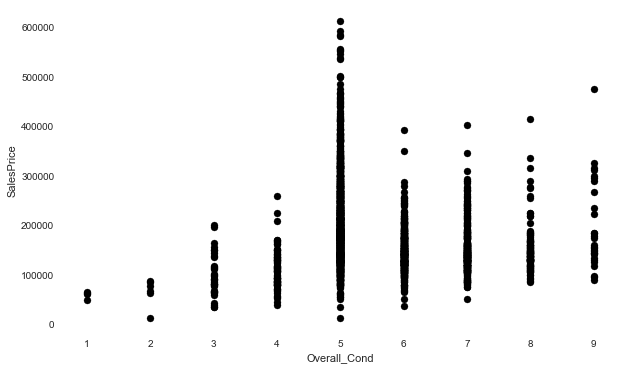

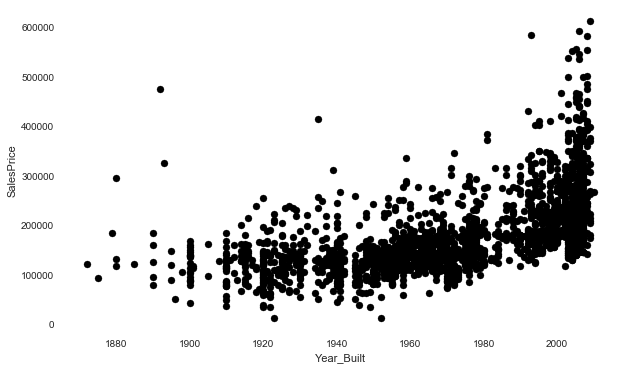

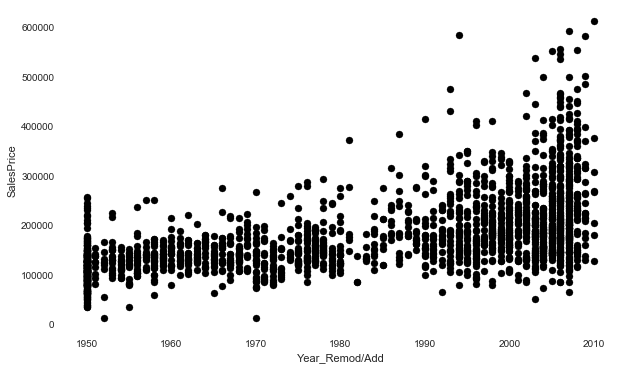

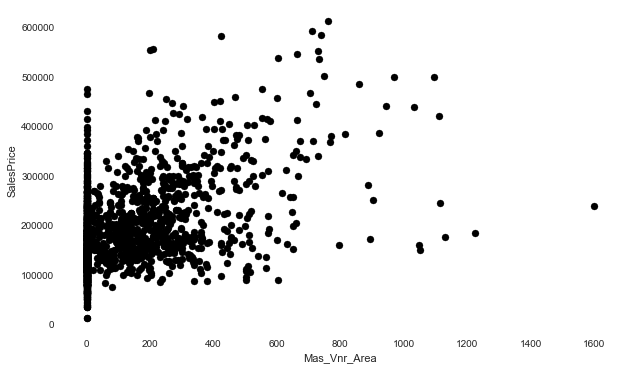

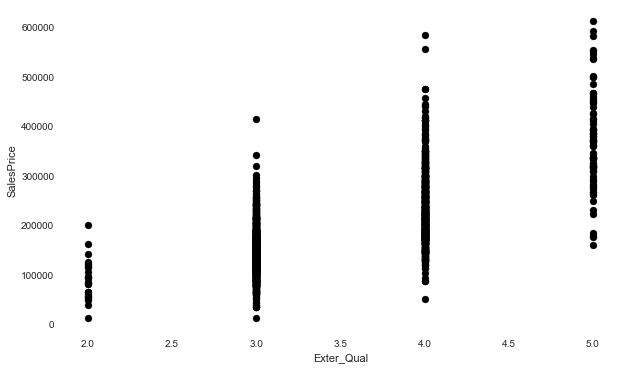

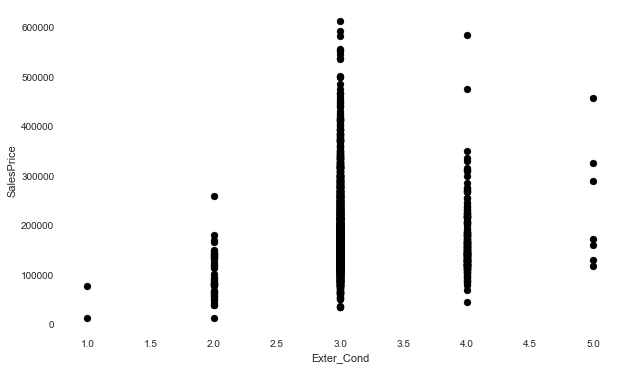

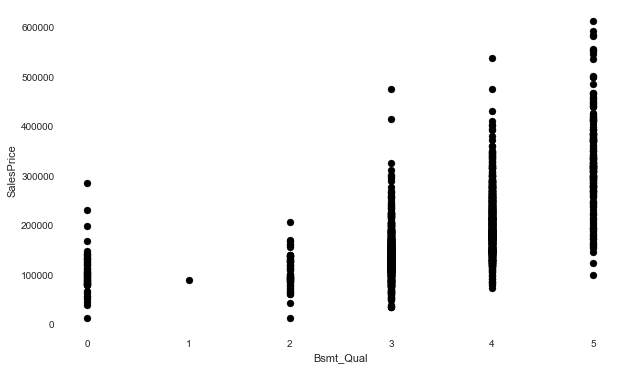

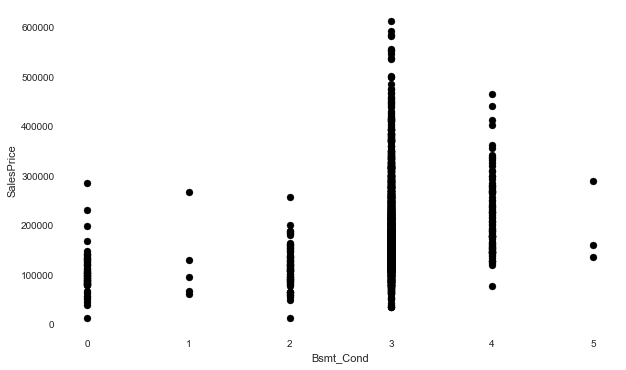

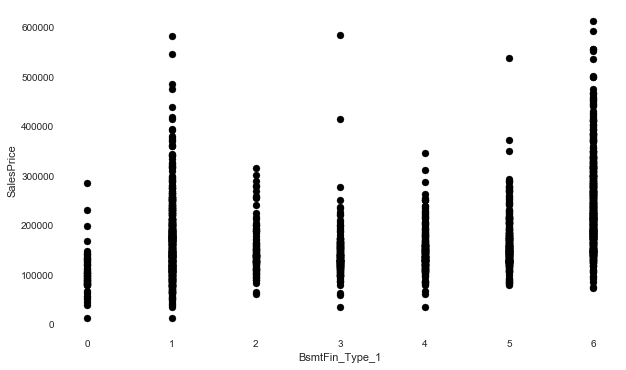

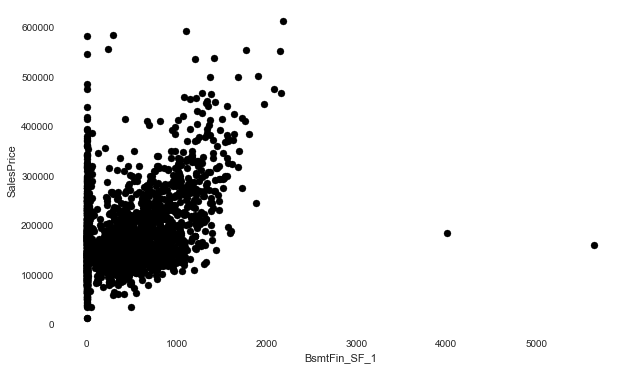

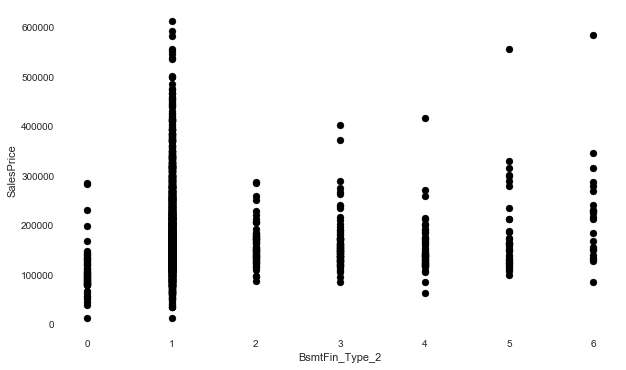

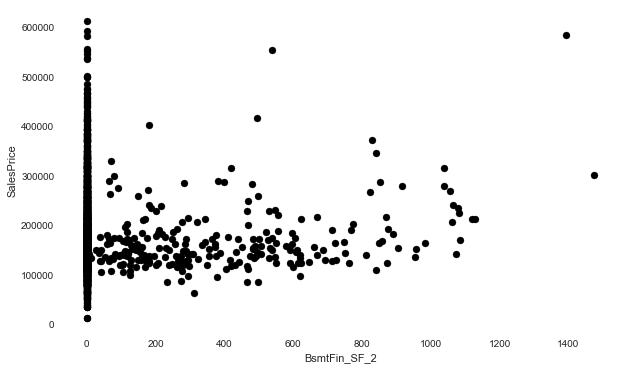

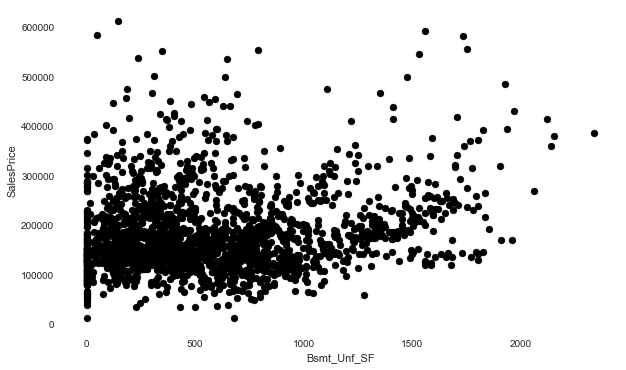

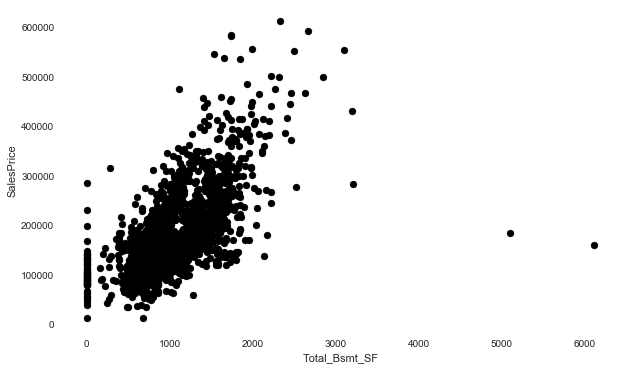

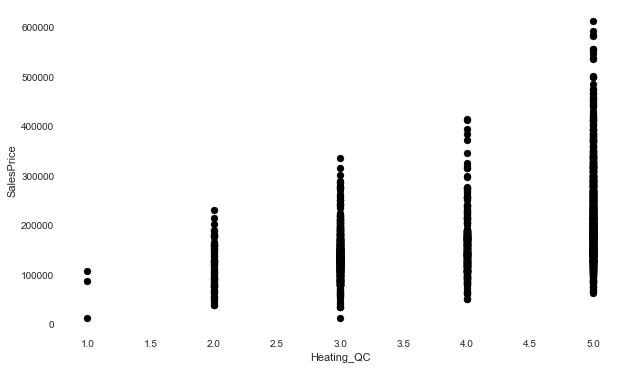

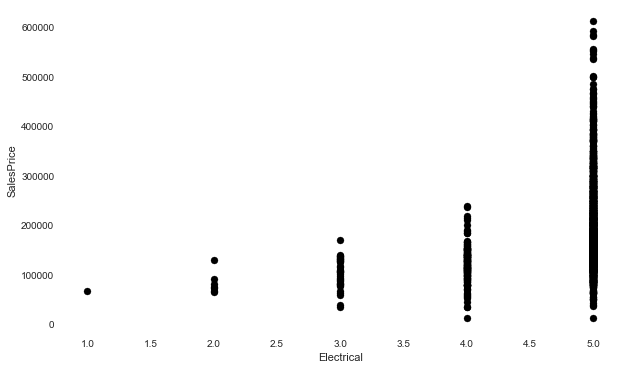

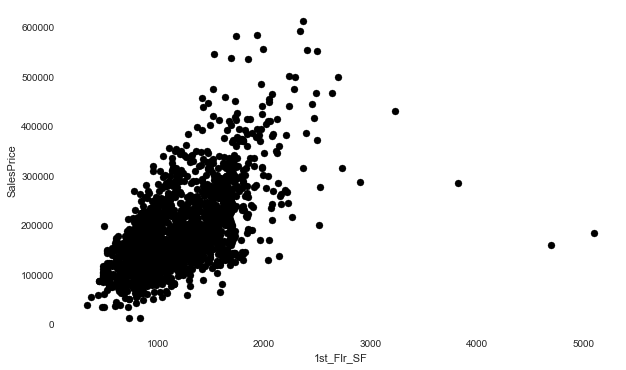

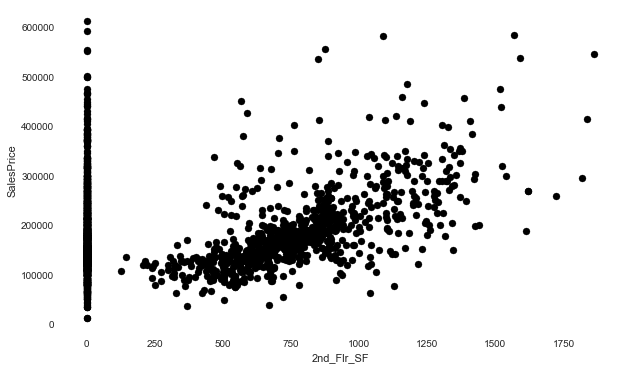

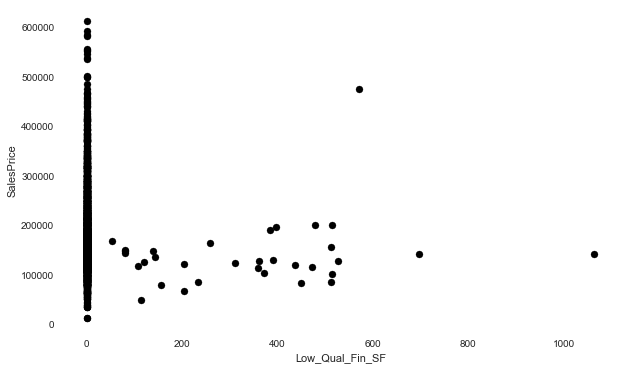

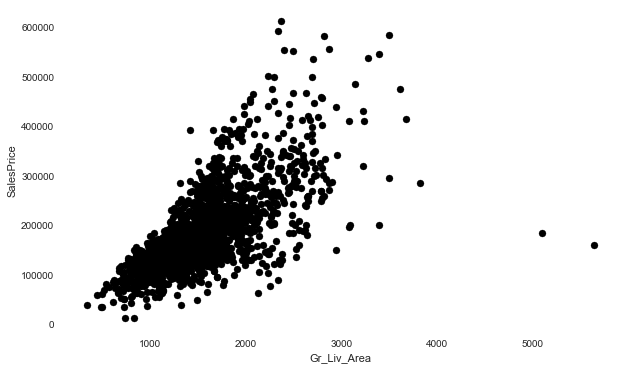

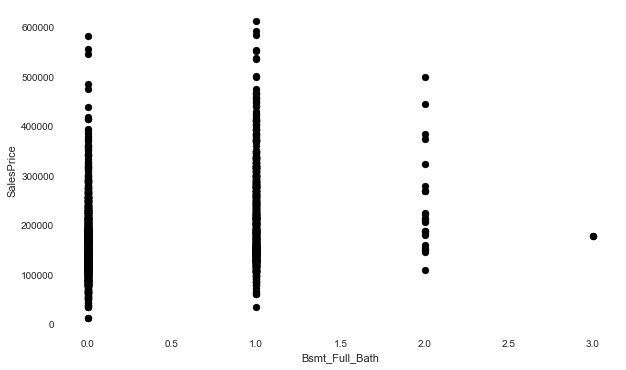

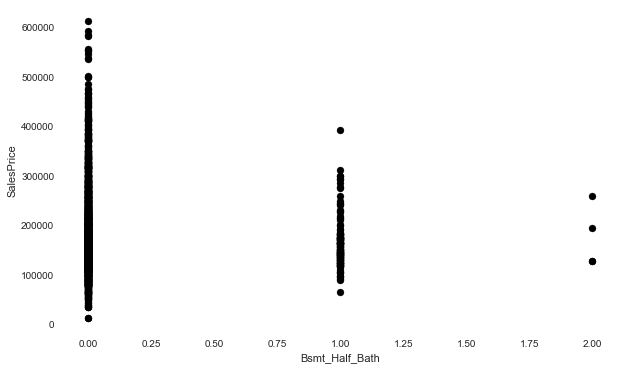

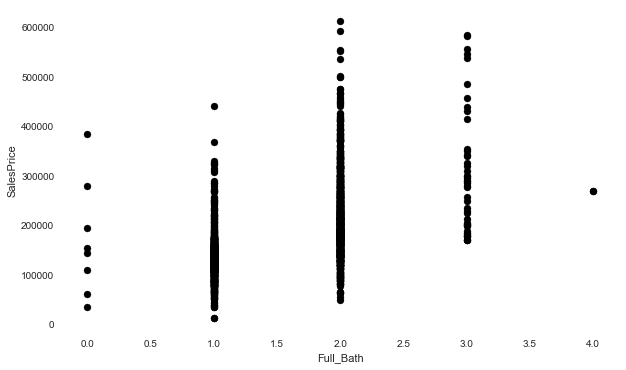

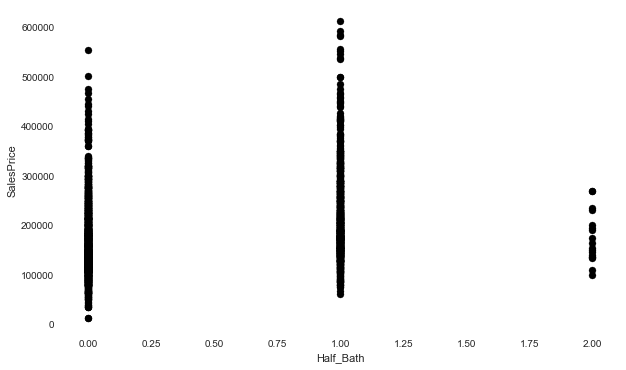

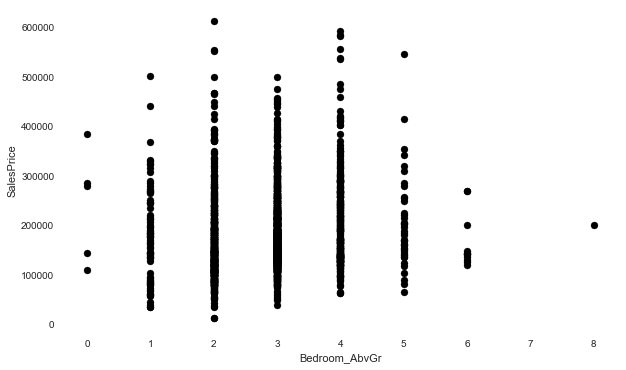

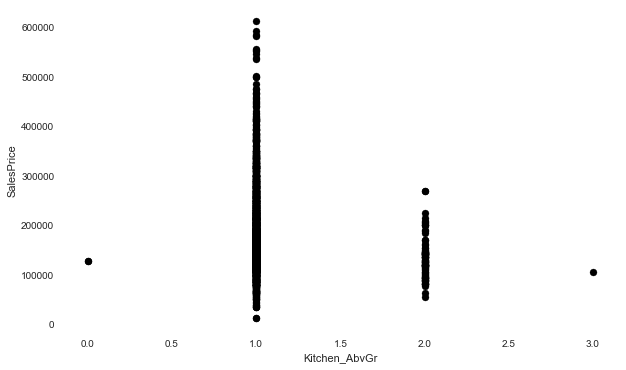

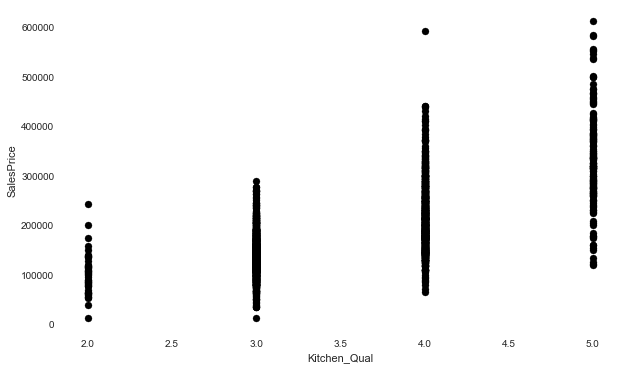

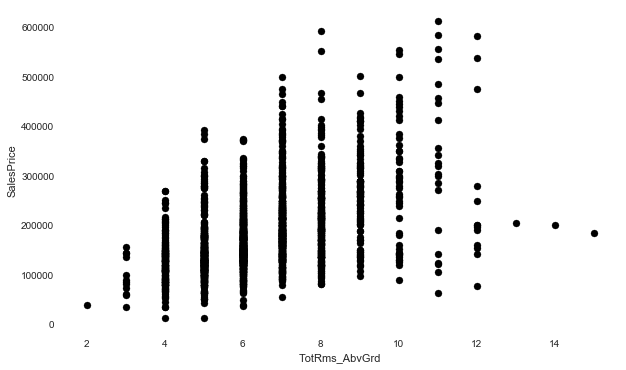

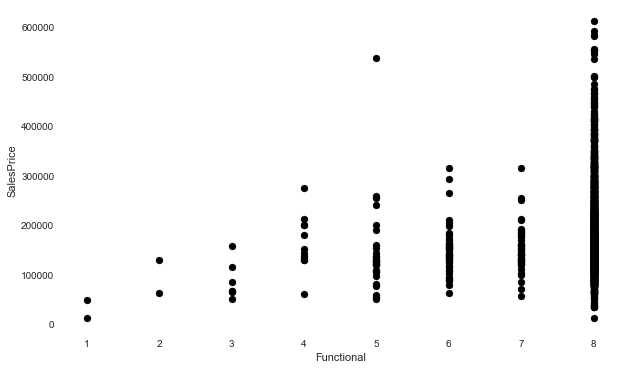

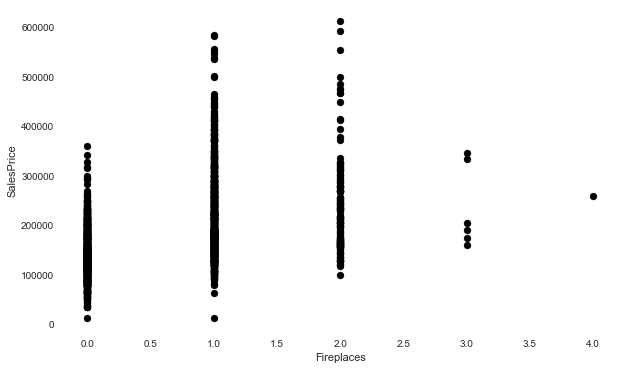

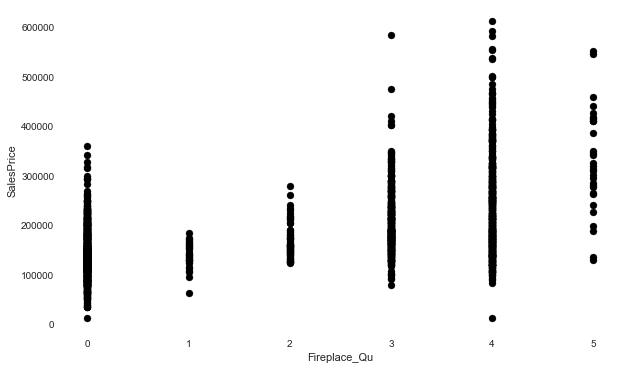

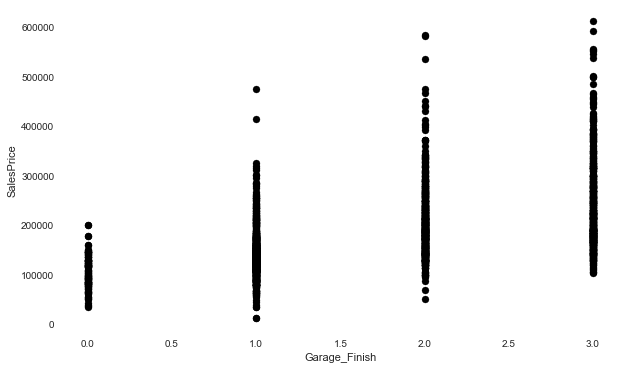

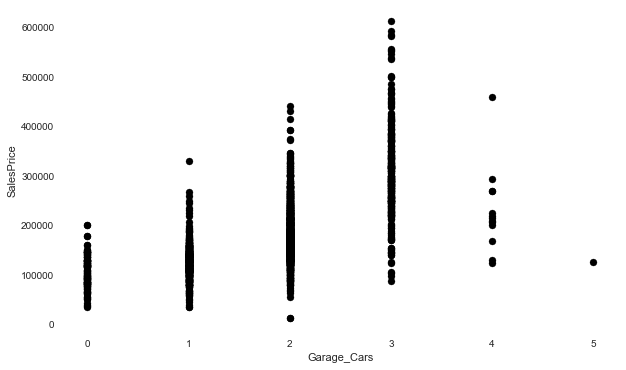

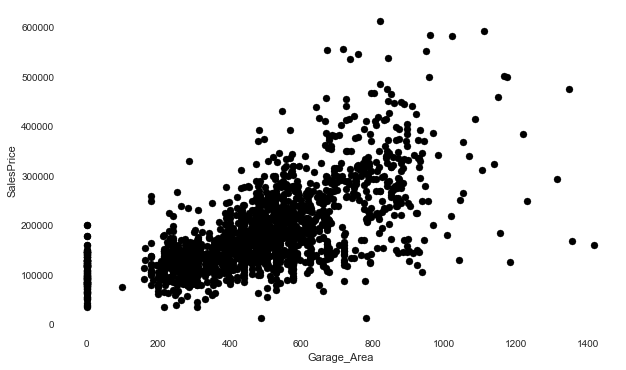

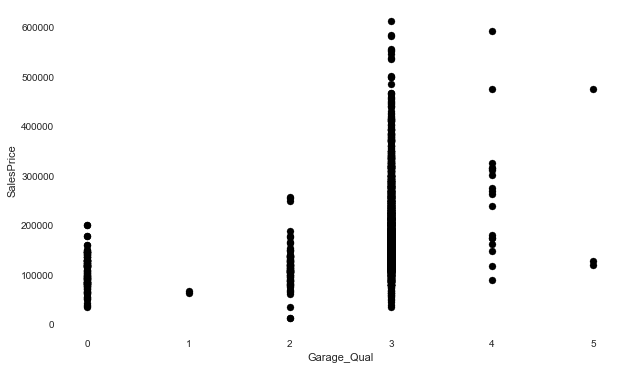

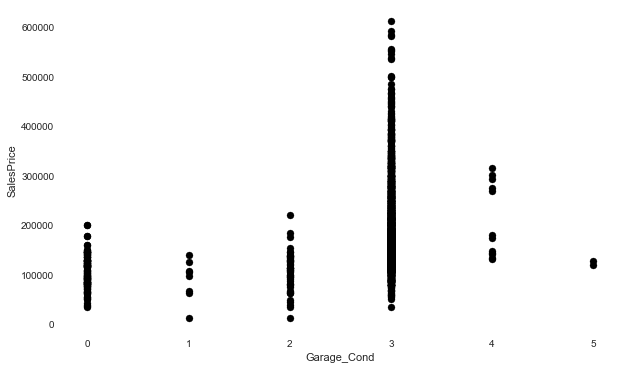

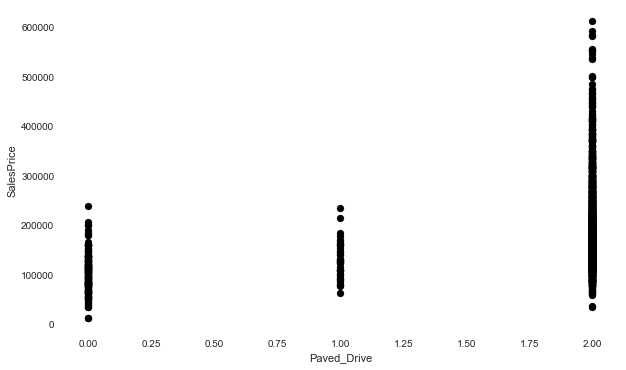

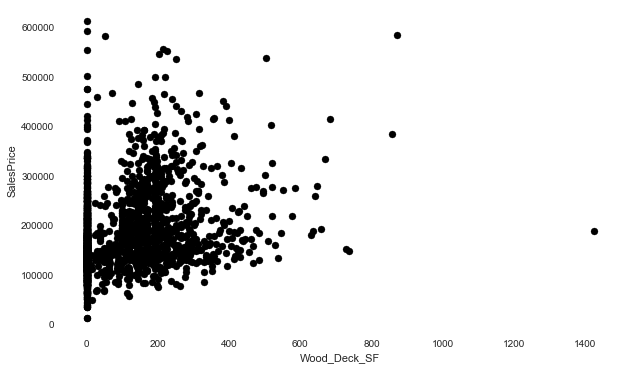

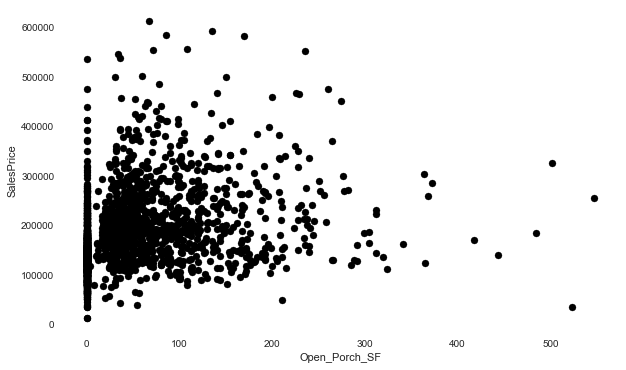

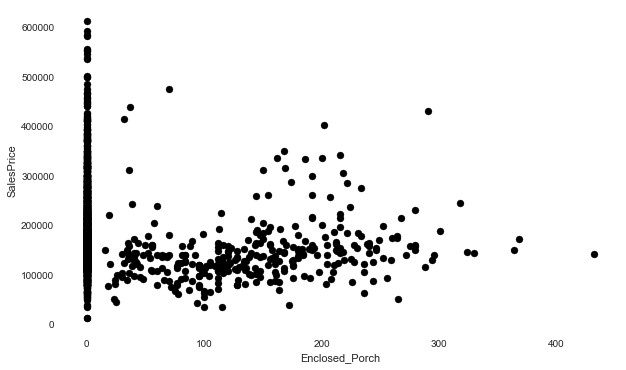

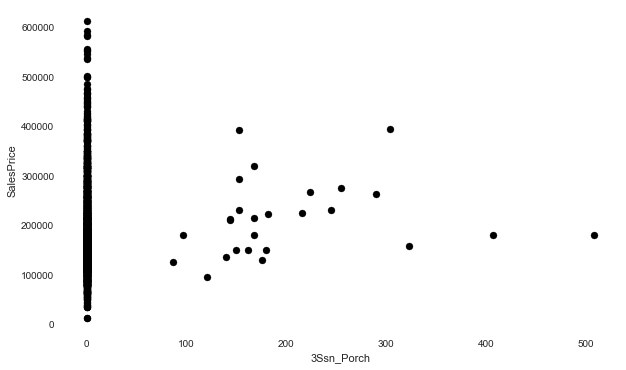

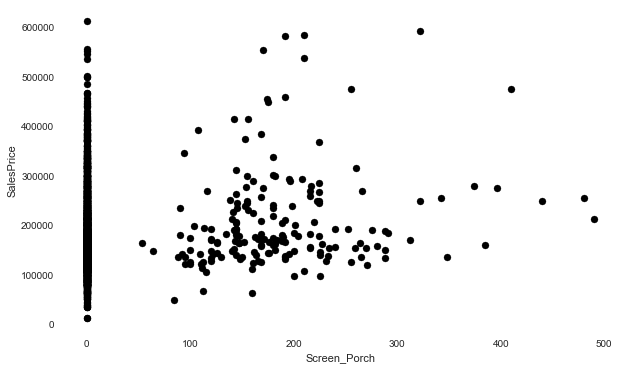

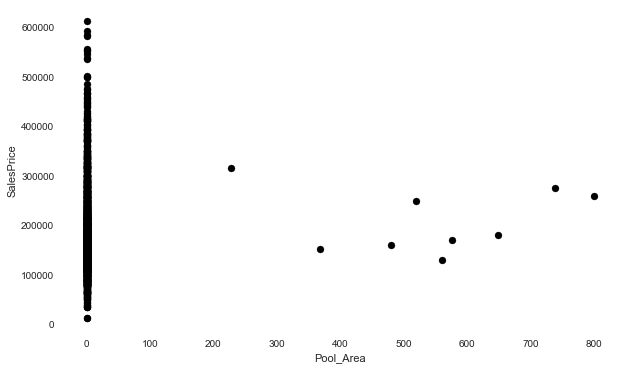

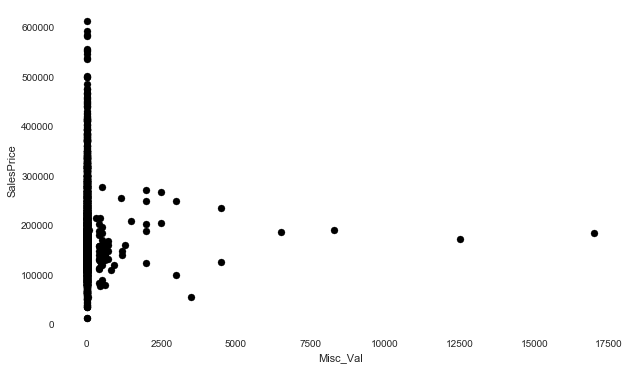

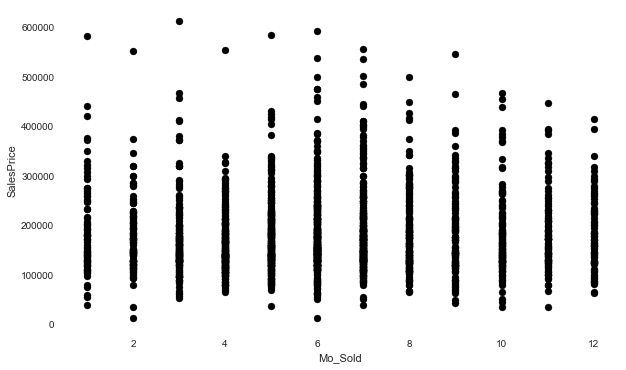

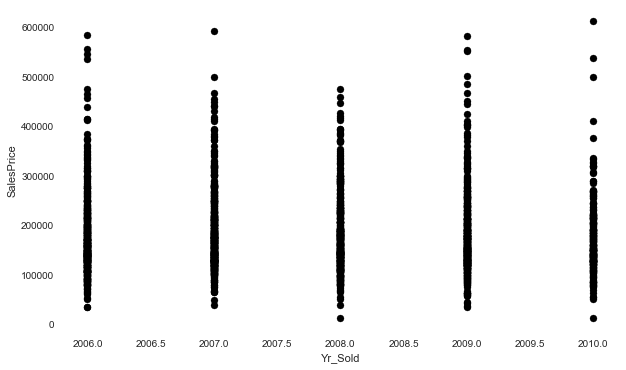

In [31]:
#plotting scatterplot to see for outliers

for i in int_float_col:
    if i != 'SalePrice':
        fig = plt.figure(figsize=(10,6))
        ax = plt.gca()
        ax.scatter(ames_int_float[i], ames_train['SalePrice'], c='k');
        plt.xlabel(i)
        plt.ylabel('SalesPrice')


In [32]:
#deleting outliners

ames_train = ames_train[ames_train['Lot_Frontage'] < 250]
ames_train = ames_train[ames_train['Lot_Area'] < 140000]
ames_train = ames_train[ames_train['Mas_Vnr_Area'] < 1400]
ames_train = ames_train[ames_train['BsmtFin_SF_1'] < 3000]
ames_train = ames_train[ames_train['BsmtFin_SF_2'] < 1400]
ames_train = ames_train[ames_train['Total_Bsmt_SF'] < 4000]
ames_train = ames_train[ames_train['1st_Flr_SF'] < 4500]
ames_train = ames_train[ames_train['Low_Qual_Fin_SF'] < 1000]
ames_train = ames_train[ames_train['Gr_Liv_Area'] < 4500]
ames_train = ames_train[ames_train['Wood_Deck_SF'] < 1400]
ames_train = ames_train[ames_train['Enclosed_Porch'] < 400]
ames_train = ames_train[ames_train['3Ssn_Porch'] < 500]

In [33]:
ames_train.shape

(2042, 213)

## [Exploratory Data Analysis & Data Visualization](#Exploratory-Data-Analysis-&-Data-Visualization)
 [Contents:](#Contents:)

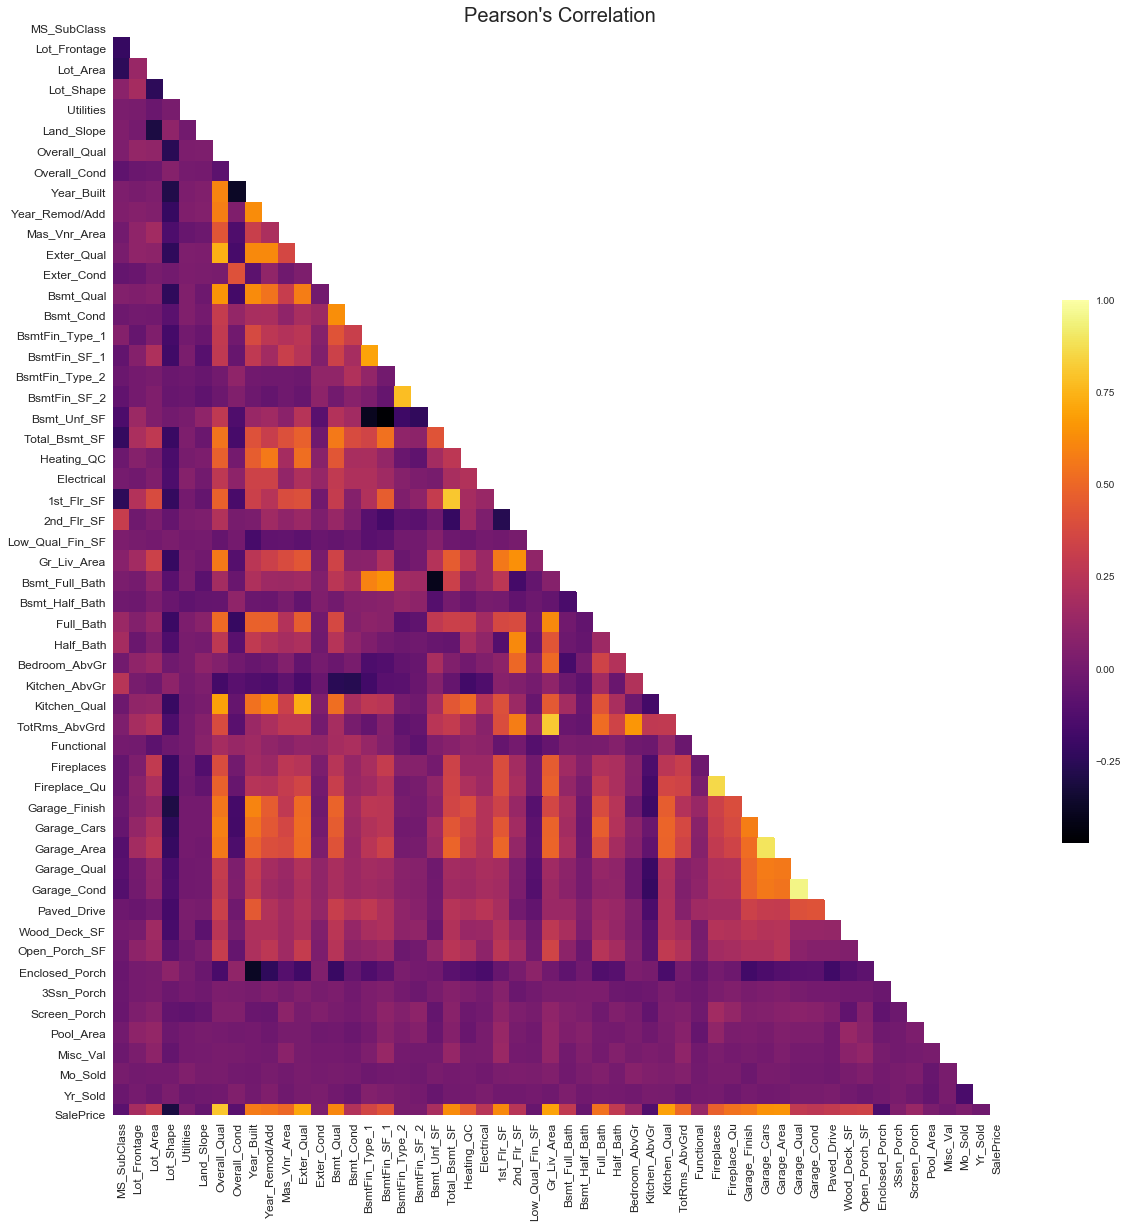

In [34]:
fig, ax  = plt.subplots(figsize=(20, 20))
ax.set_title("Pearson's Correlation", fontsize=20)

mask = np.zeros_like(ames_int_float.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

label = ames_int_float.columns
ax.set_xticklabels(label, fontsize=12)
ax.set_yticklabels(label, fontsize=12)

sns.heatmap(ames_int_float.corr(), cmap='inferno', cbar_kws={"shrink": .5}, mask=mask, ax=ax)

In [35]:
#adding high correlation column into list
high_corr_col = [x for x in ames_int_float.columns if ames_int_float[x].corr(ames_int_float['SalePrice'],method='pearson') > 0.6]
high_corr_col

#high_corr_col = ['Overall_Qual','Gr_Liv_Area','Exter_Qual','Kitchen_Qual','Total_Bsmt_SF','Garage_Area','Garage_Cars','1st_Flr_SF','Bsmt_Qual','SalePrice' ]


['Overall_Qual',
 'Exter_Qual',
 'Bsmt_Qual',
 'Total_Bsmt_SF',
 '1st_Flr_SF',
 'Gr_Liv_Area',
 'Kitchen_Qual',
 'Garage_Cars',
 'Garage_Area',
 'SalePrice']

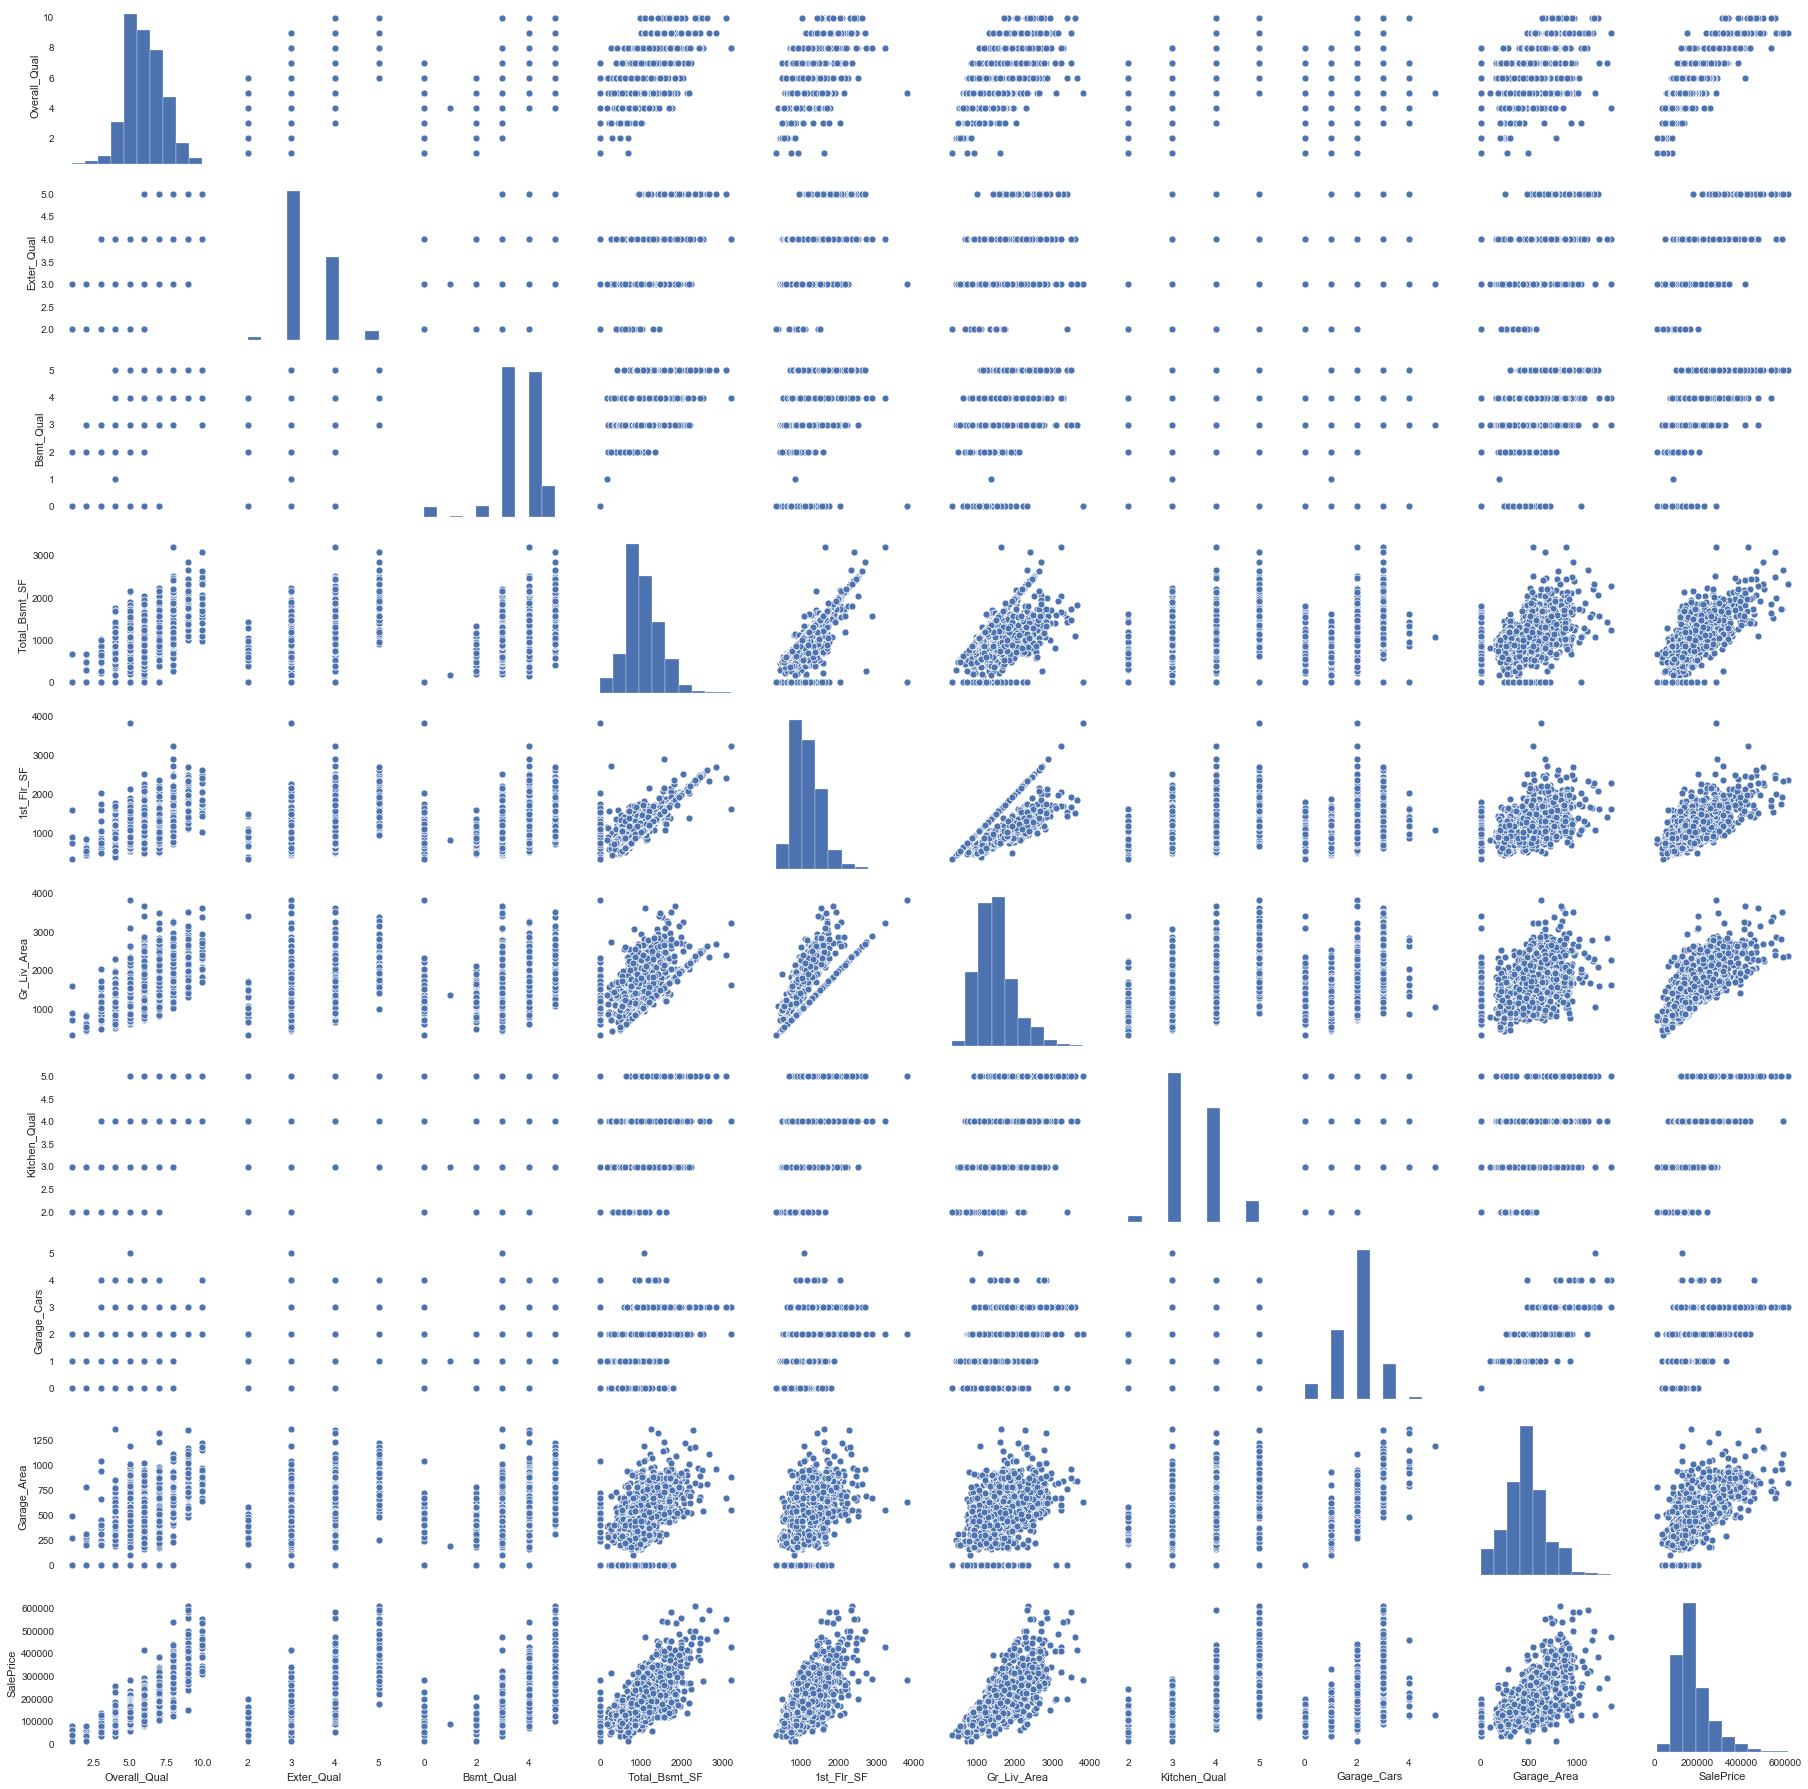

In [36]:
sns.pairplot(ames_train[high_corr_col]);

In [37]:
#adding low correlation column into list
low_corr_col = [x for x in ames_int_float.columns if x not in high_corr_col]
len(low_corr_col)

44

In [38]:
ames_train.shape

(2042, 213)

In [39]:
hse_features = {
    "2nd Flr": "2nd_Flr_SF",
    "Basement": "Total_Bsmt_SF",
    "Fireplace": "Fireplaces",
    "Garage": "Garage_Area",
    "Pool": "Pool_Area",
    "Porch": "Open_Porch_SF",
    "Wood Deck": "Wood_Deck_SF"
}

# Factorize numeric columns.
for features, column in hse_features.items():
    ames_train[features] = ames_train[column].apply(lambda x: 1 if x > 0 else 0)
    

In [40]:
ames_train[hse_features].head()

,2nd Flr,Basement,Fireplace,Garage,Pool,Porch,Wood Deck
0,1,1,0,1,0,1,0
1,1,1,1,1,0,1,0
2,0,1,0,1,0,1,0
3,1,1,0,1,0,0,1
4,1,1,0,1,0,1,0


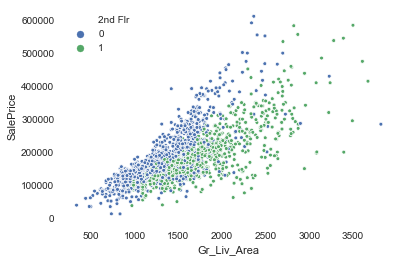

In [41]:
#From the plot below, having 2nd Flr features does not meant higher sale price

sns.scatterplot('Gr_Liv_Area','SalePrice',hue='2nd Flr', s=15, data=ames_train);

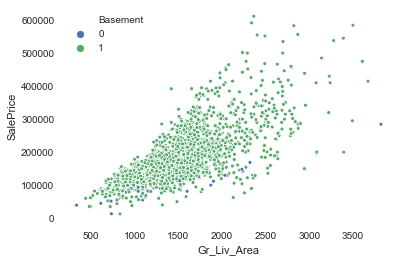

In [42]:
#From the plot below, there's a small amount of house with basement

sns.scatterplot('Gr_Liv_Area','SalePrice',hue='Basement', s=15, data=ames_train);

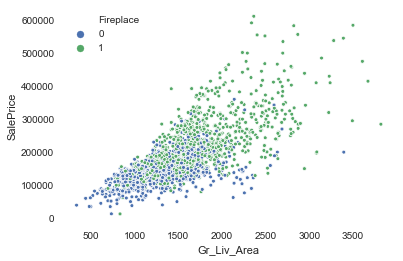

In [43]:
#From the plot below, house with fireplaces fetch a higher sale price

sns.scatterplot('Gr_Liv_Area','SalePrice',hue='Fireplace', s=15, data=ames_train);

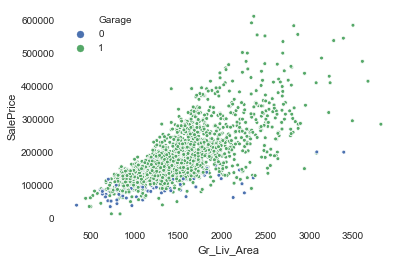

In [44]:
#From the plot below, there's a small amount of house with garage

sns.scatterplot('Gr_Liv_Area','SalePrice',hue='Garage', s=15, data=ames_train);

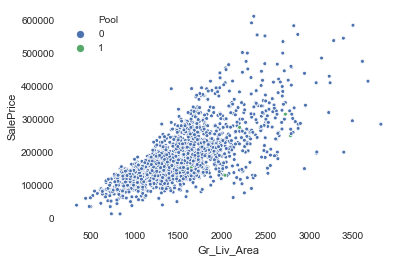

In [45]:
#From the plot below, there's a small amount of house with pool

sns.scatterplot('Gr_Liv_Area','SalePrice',hue='Pool', s=15, data=ames_train);

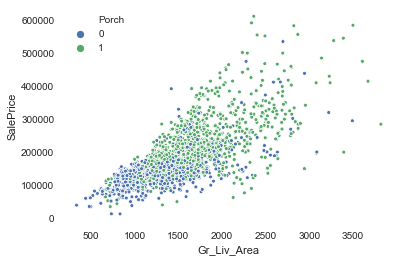

In [46]:
#Most of the house with porch fetch a higher sale price

sns.scatterplot('Gr_Liv_Area','SalePrice',hue='Porch', s=15, data=ames_train);

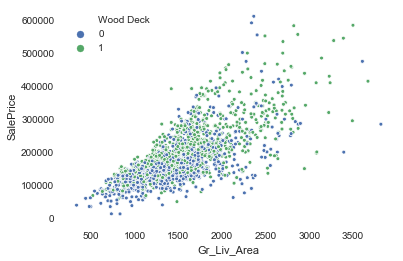

In [47]:
#Does not describe much as scatterplot are distributed

sns.scatterplot('Gr_Liv_Area','SalePrice',hue='Wood Deck', s=15, data=ames_train);

## [Modeling](#Modeling)
[Contents:](#Contents:)

In [48]:
target = ['SalePrice']

X = ames_train.drop(low_corr_col, axis =1)
X = X.drop(target, axis =1)
y = ames_train['SalePrice']

In [49]:
X.shape

(2042, 175)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)
print(X_train.shape, X_test.shape, X.shape)
print(y_train.shape, y_test.shape, y.shape)

(1531, 175) (511, 175) (2042, 175)
(1531,) (511,) (2042,)


In [51]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#### LinearRegression()

In [52]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
lm_score = cross_val_score(lm, X_train_scaled, y_train, cv = 5)

# print the results
print('LinearRegression CV mean: {0:.4f}'.format(lm_score.mean()))
print('Score: {}'.format(lm_score))

LinearRegression CV mean: -66180058327225741590134784.0000
Score: [-1.94895091e+26 -1.59767648e+25 -9.95594982e+25 -2.03721040e+25
 -9.68335770e+22]


In [55]:
y_hat_lm = lm.predict(X_test_scaled)

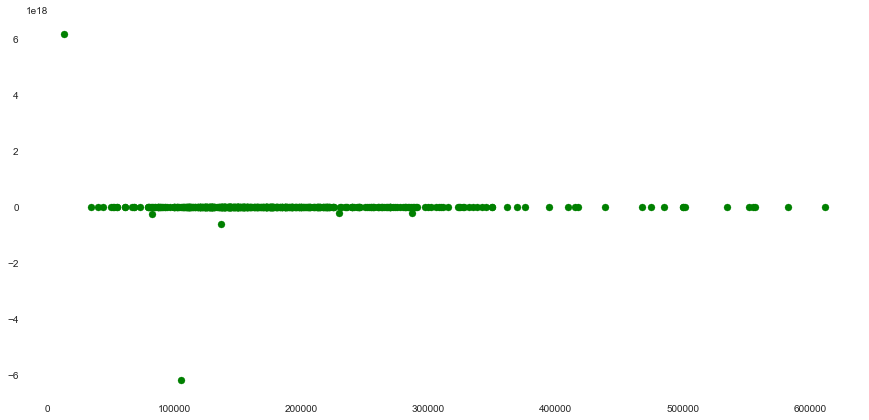

In [56]:
# create a figure
fig = plt.figure(figsize=(15,7))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on DEPTH with our data
ax.scatter(y_test, y_hat_lm, c='g');

In [48]:
#from sklearn.neighbors import KNeighborsClassifier

In [49]:
#knn = KNeighborsClassifier()
#knn.fit(X_train_scaled, y_train)

In [50]:
#knn.score(X_train_scaled, y_train)

In [51]:
#knn.score(X_test_scaled, y_test)

In [52]:
#print (np.mean(y_test))

#### Ridge & RidgeCV()

In [57]:
r_alphas = np.logspace(-1, 5, 1000)
ridge_ames = RidgeCV(alphas=r_alphas, store_cv_values=True)
ridge_ames = ridge_ames.fit(X_train_scaled, y_train)
ridge_ames.score(X_train_scaled, y_train)

0.9071492343883976

In [58]:
ridge_ames.alpha_

261.4673211801092

In [59]:
ridge_alpha = Ridge(ridge_ames.alpha_).fit(X_train_scaled, y_train)
ridge_alpha.score(X_train_scaled, y_train)

0.9071492343883956

In [60]:
ridge_score = cross_val_score(ridge_alpha, X_train_scaled, y_train, cv = 5)

# print the results
print('Ridge CV mean: {0:.4f}'.format(ridge_score.mean()))
print('Score: {}'.format(ridge_score))

Ridge CV mean: 0.8855
Score: [0.83867337 0.8977462  0.89788122 0.89660244 0.89635843]


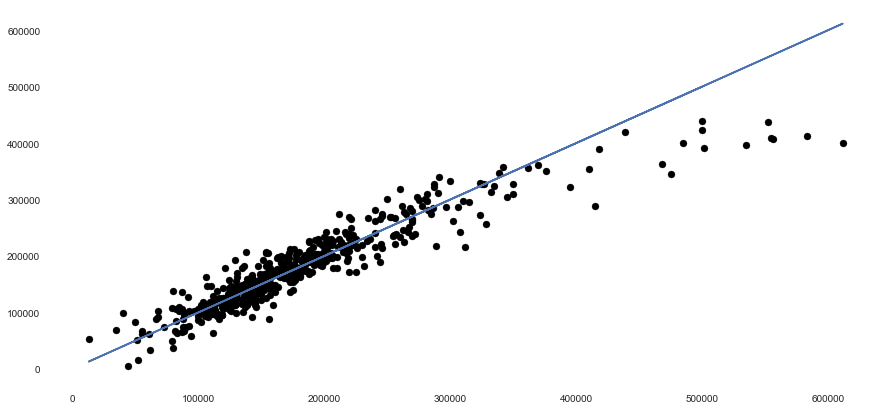

In [61]:
y_hat_ridge = ridge_alpha.predict(X_test_scaled)

# create a figure
fig = plt.figure(figsize=(15,7))
# get the axis of that figure
ax = plt.gca()

ax.plot(y_test,y_test)

# plot a scatter plot on DEPTH with our data
ax.scatter(y_test, y_hat_ridge, c='k');

#### Lasso & LassoCV()

In [62]:
#l_alphas = np.arange(0.001, 0.15, 0.0025)

lasso_ames = LassoCV(n_alphas=1000, cv=10)
lasso_ames = lasso_ames.fit(X_train_scaled, y_train)
lasso_ames.score(X_train_scaled, y_train)

0.9074097231872568

In [63]:
lasso_ames.alpha_

453.2922355556098

In [64]:
lasso_alpha = Lasso(lasso_ames.alpha_).fit(X_train_scaled, y_train)
lasso_alpha.score(X_train_scaled, y_train)

0.9074097231872568

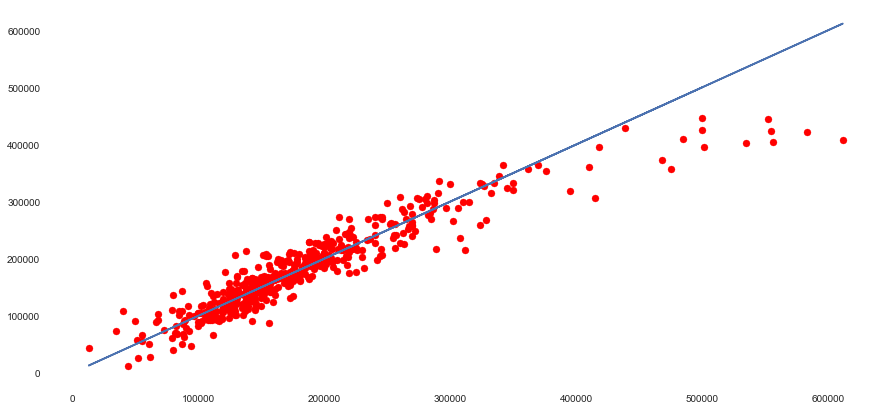

In [65]:
y_hat_lasso = lasso_alpha.predict(X_test_scaled)

# create a figure
fig = plt.figure(figsize=(15,7))
# get the axis of that figure
ax = plt.gca()

ax.plot(y_test,y_test)

# plot a scatter plot on DEPTH with our data
ax.scatter(y_test, y_hat_lasso, c='r');

In [66]:
coef = pd.DataFrame(abs(lasso_alpha.coef_), index = X.columns)
coef.columns = ['lasso_coef']
print(coef[coef['lasso_coef']==0].count()/coef['lasso_coef'].count()*100)

lasso_coef    44.571429
dtype: float64


In [67]:
coef.sort_values('lasso_coef', ascending=False).head(30)

,lasso_coef
Gr_Liv_Area,21954.510363
Overall_Qual,12131.179238
Total_Bsmt_SF,10627.330655
NridgHt,7774.617628
Bsmt_Qual,7532.736761
1Fam,7368.206116
Kitchen_Qual,7242.819332
Garage_Area,6984.334860
Gd,5382.707173
NoRidge,5318.223554


In [68]:
top_15 = ['Gr_Liv_Area','Overall_Qual','Total_Bsmt_SF','Kitchen_Qual','Garage_Area','Bsmt_Qual','1Fam','Exter_Qual','NridgHt','NoRidge','StoneBr','Garage_Cars','1st_Flr_SF','HLS','New']

X_new = ames_train[top_15]
y_new = ames_train['SalePrice']

#### <summary>From Lasso, I picked up 15 ideal columns to do a prediction model for my test dataset.</summary>

In [69]:
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new, y_new, random_state=40)
print(Xnew_train.shape, Xnew_test.shape, X_new.shape)
print(ynew_train.shape, ynew_test.shape, y_new.shape)

(1531, 15) (511, 15) (2042, 15)
(1531,) (511,) (2042,)


#### Lasso with Grid Search

In [71]:
# instantiate the regression
lasso = Lasso(normalize=False)

# create a paramter dictionary of different alpha values
lasso_params = {'alpha':np.linspace(.1,10,50)}

# call the grid search on the model
grid_lasso = GridSearchCV(lasso, lasso_params, cv = 5, verbose = 1, n_jobs = -1)

# fit the model on the data
grid_lasso.fit(Xnew_train, ynew_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,  0.90816327,
        1.11020408,  1.312244...
        5.15102041,  5.35306122,  5.55510204,  5.75714286,  5.95918367,
        6.16122449,  6.36326531,  6.56530612,  6.76734694,  6.96938776,
        7.17142857,  7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
        8.18163265,  8.38367347,  8.58571429,  8.7877551 ,  8.98979592,
        9.19183673,  9.39387755,  9.59591837,  9.79795918, 10.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [72]:
# print search results
print('The average lasso score is: {}'.format(grid_lasso.cv_results_['mean_test_score'].mean()))
print('The best lasso score is: {}'.format(grid_lasso.best_score_))
print('The best lasso model is: {}'.format(grid_lasso.best_estimator_))

The average lasso score is: 0.8637330255267109
The best lasso score is: 0.8637362447082338
The best lasso model is: Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


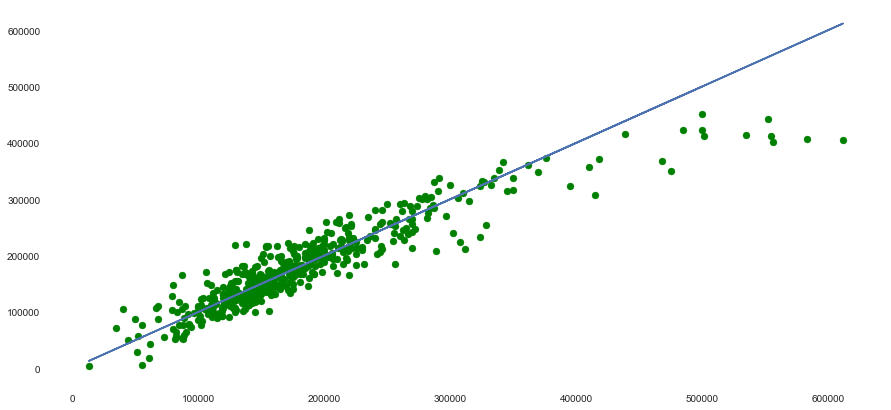

In [73]:
y_hat_grid = grid_lasso.predict(Xnew_test)

# create a figure
fig = plt.figure(figsize=(15,7))
# get the axis of that figure
ax = plt.gca()

ax.plot(ynew_test,ynew_test)

# plot a scatter plot on DEPTH with our data
ax.scatter(ynew_test, y_hat_grid, c='g');

In [74]:
#Getting RMSE

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(ynew_test, y_hat_grid))
rms

32127.925771334587

## [Ames Housing-Test Dataset](#Ames-Housing-Test-Dataset)
[Contents:](#Contents:)

In [76]:
### Original Code: ames_test = pd.read_csv('../project_2/datasets/test.csv')
ames_test = pd.read_csv('./datasets/test.csv')

In [77]:
ames_test.columns = [x.replace(' ', '_') for x in ames_test.columns]
ames_test.head()

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [78]:
print(ames_test.shape)

(879, 80)


In [79]:
print(ames_test.isnull().sum().sum())

4175


In [80]:
ames_result = pd.DataFrame(ames_test['Id'])

In [81]:
ames_test.drop(irre_col, axis=1, inplace=True)

In [82]:
print(ames_test.shape)

(879, 74)


In [83]:
MSZoning_dummy = pd.get_dummies(ames_test['MS_Zoning'], columns = ['RL', 'RM', 'FV', 'C (all)', 'A (agr)', 'RH', 'I (all)'])
Street_dummy = pd.get_dummies(ames_test['Street'], columns = ['Pave', 'Grvl'])
ames_test['Alley'] = ames_test['Alley'].fillna('NA') #assuming nan-values as No alley access 
Alley_dummy = pd.get_dummies(ames_test['Alley'], columns = ['NA', 'Pave', 'Grvl'])
LandContour_dummy = pd.get_dummies(ames_test['Land_Contour'], columns = ['Lvl', 'HLS', 'Bnk', 'Low'])
LotConfig_dummy = pd.get_dummies(ames_test['Lot_Config'], columns = ['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3']) 
Neighborhood_dummy = pd.get_dummies(ames_test['Neighborhood'], columns = ['Sawyer', 'SawyerW', 'NAmes', 'Timber', 'Edwards', 'OldTown',
       'BrDale', 'CollgCr', 'Somerst', 'Mitchel', 'StoneBr', 'NridgHt',
       'Gilbert', 'Crawfor', 'IDOTRR', 'NWAmes', 'Veenker', 'MeadowV',
       'SWISU', 'NoRidge', 'ClearCr', 'Blmngtn', 'BrkSide', 'NPkVill',
       'Blueste', 'GrnHill', 'Greens', 'Landmrk'])
Condition1_dummy = pd.get_dummies(ames_test['Condition_1'], columns = ['RRAe', 'Norm', 'PosA', 'Artery', 'Feedr', 'PosN', 'RRAn', 'RRNe','RRNn'])
Condition2_dummy = pd.get_dummies(ames_test['Condition_2'], columns = ['RRAe', 'Norm', 'PosA', 'Artery', 'Feedr', 'PosN', 'RRAn', 'RRNe','RRNn'])
BldgType_dummy = pd.get_dummies(ames_test['Bldg_Type'], columns = ['1Fam', 'TwnhsE', 'Twnhs', '2fmCon', 'Duplex'])
HouseStyle_dummy = pd.get_dummies(ames_test['House_Style'], columns = ['2Story', '1Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin','1.5Unf'])
RoofStyle_dummy = pd.get_dummies(ames_test['Roof_Style'], columns = ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed'])
RoofMatl_dummy = pd.get_dummies(ames_test['Roof_Matl'], columns = ['CompShg', 'WdShngl', 'Tar&Grv', 'WdShake', 'Membran', 'ClyTile'])
Exterior1_dummy = pd.get_dummies(ames_test['Exterior_1st'], columns = ['HdBoard', 'VinylSd', 'Wd Sdng', 'BrkFace', 'Plywood', 'MetalSd', 'AsbShng', 'CemntBd', 'WdShing', 'Stucco', 'BrkComm', 'Stone', 'CBlock', 'ImStucc', 'AsphShn'])
Exterior2_dummy = pd.get_dummies(ames_test['Exterior_2nd'], columns = ['HdBoard', 'VinylSd', 'Wd Sdng', 'BrkFace', 'Plywood', 'MetalSd', 'AsbShng', 'CemntBd', 'WdShing', 'Stucco', 'BrkComm', 'Stone', 'CBlock', 'ImStucc', 'AsphShn'])
ames_test['Mas_Vnr_Type'] = ames_test['Mas_Vnr_Type'].fillna('None')
MasVnrType_dummy = pd.get_dummies(ames_test['Mas_Vnr_Type'], columns = ['BrkCmn','BrkFace','CBlock','None','Stone'])
Foundation_dummy = pd.get_dummies(ames_test['Foundation'], columns = ['CBlock', 'PConc', 'BrkTil', 'Slab', 'Stone', 'Wood'])
ames_test['Bsmt_Exposure'] = ames_test['Bsmt_Exposure'].fillna('NA')
Exposure_dummy = pd.get_dummies(ames_test['Bsmt_Exposure'], columns = ['Gd','Av','Mn','No','NA'])
Heating_dummy = pd.get_dummies(ames_test['Heating'], columns = ['Floor','GasA','GasW','Grav','OthW','Wall'])
CentralAir_dummy = pd.get_dummies(ames_test['Central_Air'], columns = ['Y', 'N'])
ames_test['Garage_Type'] = ames_test['Garage_Type'].fillna('NA') #assuming nan-values as No Garage
GarageType_dummy = pd.get_dummies(ames_test['Garage_Type'], columns = ['Attchd', 'Detchd', 'BuiltIn', 'Basment', 'NA', '2Types','CarPort'])
SaleType_dummy = pd.get_dummies(ames_test['Sale_Type'], columns = ['WD','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth'])

In [84]:
ames_test = pd.concat([ames_test,MSZoning_dummy,Street_dummy,Alley_dummy,LandContour_dummy,LotConfig_dummy,Neighborhood_dummy,Condition1_dummy,Condition2_dummy,BldgType_dummy,HouseStyle_dummy,RoofStyle_dummy,RoofMatl_dummy,Exterior1_dummy,Exterior2_dummy,MasVnrType_dummy,Foundation_dummy,Exposure_dummy,Heating_dummy,CentralAir_dummy,GarageType_dummy,SaleType_dummy], axis = 1)

In [85]:
#dummy_col = ['MS_Zoning', 'Alley', 'Land_Contour', 'Lot_Config', 'Neighborhood', 'Condition_1', 'Bldg_Type', 'House_Style', 'Roof_Matl', 'Exterior_1st', 'Foundation', 'Central_Air', 'Garage_Type']
ames_test.drop(columns = dummy_col, inplace = True)

In [86]:
print(ames_test.shape)

(879, 205)


In [87]:
ames_test.Lot_Shape = ames_test.Lot_Shape.apply(lambda x: 1 if x == 'Reg' else 0)
ames_test.Utilities = ames_test.Utilities.map({'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1})
ames_test.Land_Slope = ames_test.Land_Slope.map({'Gtl':3,'Mod':2,'Sev':1})
ames_test.Exter_Qual = ames_test.Exter_Qual.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
ames_test.Exter_Cond = ames_test.Exter_Cond.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
ames_test.Bsmt_Qual = ames_test.Bsmt_Qual.fillna('NA') #assuming nan-values as No Basement
ames_test.Bsmt_Qual = ames_test.Bsmt_Qual.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_test.Bsmt_Cond = ames_test.Bsmt_Cond.fillna('NA') #assuming nan-values as No Basement
ames_test.Bsmt_Cond = ames_test.Bsmt_Cond.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_test.BsmtFin_Type_1 = ames_test.BsmtFin_Type_1.fillna('NA') #assuming nan-values as No Basement
ames_test.BsmtFin_Type_1 = ames_test.BsmtFin_Type_1.map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0})
ames_test.BsmtFin_Type_2 = ames_test.BsmtFin_Type_2.fillna('NA') #assuming nan-values as No Basement
ames_test.BsmtFin_Type_2 = ames_test.BsmtFin_Type_2.map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0})
ames_test.Heating_QC = ames_test.Heating_QC.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
ames_test.Electrical = ames_test.Electrical.fillna('NA')
ames_test.Electrical = ames_test.Electrical.map({'SBrkr':5,'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1,'NA':0})
ames_test.Kitchen_Qual = ames_test.Kitchen_Qual.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
ames_test.Functional = ames_test.Functional.map({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1})
ames_test.Fireplace_Qu = ames_test.Fireplace_Qu.fillna('NA') #assuming nan-values as No Fireplace
ames_test.Fireplace_Qu = ames_test.Fireplace_Qu.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_test.Garage_Finish = ames_test.Garage_Finish.fillna('NA') #assuming nan-values as No Garage
ames_test.Garage_Finish = ames_test.Garage_Finish.map({'Fin':3,'RFn':2,'Unf':1,'NA':0})
ames_test.Garage_Qual = ames_test.Garage_Qual.fillna('NA') #assuming nan-values as No Garage
ames_test.Garage_Qual = ames_test.Garage_Qual.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_test.Garage_Cond = ames_test.Garage_Cond.fillna('NA') #assuming nan-values as No Garage
ames_test.Garage_Cond = ames_test.Garage_Cond.map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
ames_test.Paved_Drive = ames_test.Paved_Drive.map({'Y':2,'P':1,'N':0})

In [88]:
print(ames_test.shape)

(879, 205)


In [89]:
zero_col = ['Lot_Frontage','Mas_Vnr_Area','BsmtFin_SF_1','BsmtFin_SF_2','Bsmt_Unf_SF','Total_Bsmt_SF','Bsmt_Full_Bath','Bsmt_Half_Bath','Garage_Cars','Garage_Area']

ames_test[zero_col] = ames_test[zero_col].fillna(0)

In [90]:
ames_test.shape

(879, 205)

In [91]:
ames_test.isnull().sum().sum()

0

### Testing test dataset with GridSearchLasso predict

In [92]:
X_new.shape

(2042, 15)

In [93]:
final = ames_test[top_15]

In [94]:
missing_col = [x for x in X_new.columns if x not in final.columns]

In [95]:
missing_col

[]

In [96]:
y_hat_test = grid_lasso.predict(final)
#ames_result = pd.concat([ames_result['Id'], pd.DataFrame(y_hat_test)],axis=1)

In [97]:
ames_result = pd.DataFrame(y_hat_test, index=ames_result['Id'])

In [98]:
ames_result.columns = ['SalePrice']

In [99]:
### Original Code: ames_result.to_csv('../project_2/datasets/ames_result.csv')
ames_result.to_csv('./datasets/ames_result.csv')

In [100]:
ames_result

,SalePrice
Id,
2658,136077.982329
2718,199972.812338
2414,198508.395694
1989,136275.790213
625,177468.457884
...,...
1662,178133.805422
1234,208072.160495
1373,131316.703294


## [Outside Research](#Outside-Research)
[Contents:](#Contents:)

#### Information from Wikipedia on Ames, Iowa

Ames, which is a city in central Iowa,had a population of 66,498. Iowa State University is home to 36,321 students (Fall 2017), which make up approximately one half of the city's population. There were 22,759 households of which 30.5% of all households were made up of individuals.
  - Perhaps this might be infer as students coming together to purchase houses or houseowner purchasing bigger house to     accomodate students in their house as another source of income. 
  
The Bureau of Labor Statistics ranked Ames as having the lowest unemployment rate (2.5%) of any metropolitan area in the US in 2016. By June 2018, unemployment in Ames had fallen even further, to 1.5%, and wage increases for workers were not keeping pace with rising rents.

Also, we seen that most of the houses have fireplaces or heating system in place. This is because Iowa, at winter season, the temperature can go as low as -10°C. Due to the same reason, we see that there's a particularly low number of houses with pool. Therefore, houses with one or more fireplace can generally fetch a higher sale price.
